Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects, each with its own bounding box and a label (e.g. it can have a car and a building), and each object can be present in different parts of an image (e.g. the image can have several cars). This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights. Other applications include counting objects in images, image search, and more.

In this guide, you will learn how to:

Finetune DETR, a model that combines a convolutional backbone with an encoder-decoder Transformer, on the CPPE-5 dataset.
Use your finetuned model for inference.

Before you begin, make sure you have all the necessary libraries installed:https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?resource=download

In [7]:
! pip install -q split-folders

In [8]:
import os                                         # To work with OS commands
import warnings                                   # To avoid python warnings
import random                                     # To generate random choices
from PIL import Image                             # To read Images
import numpy as np                                # To work with Numpy arrays
import matplotlib.pyplot as plt                   # To Visualization
import seaborn as sns                             # To Visualization
import splitfolders                               # To split data to train, test and validation folders
from termcolor import colored                     # To Colorfull output
from datetime import datetime                     # To calculate durations

import torch                                      # To work with TORCH framework
import torch.nn as nn                             # To work with Neural Networks
import torchvision                                # To work with image datasets
import torchvision.transforms as transforms       # To create data transforms

from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights, googlenet, GoogLeNet_Weights # Pretrained model with its weights
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
sns.set_style('darkgrid')

# Avoid warnings
warnings.filterwarnings('ignore')

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


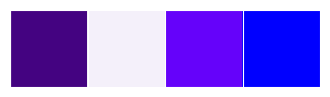

In [11]:
colors_dark = ["#440381", '#f4f0fa', '#6502fa', "blue"]

sns.palplot(colors_dark)

In [12]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Flowers'
os.listdir(base_dir)

['dandelion', 'sun flower', 'daisy', 'tulip', 'rose']

In [13]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Flowers' # Verify that this path is correct
classes = os.listdir(base_dir)
print(f'Number of classes : {len(classes)}')
print(f'Classes : {classes}')

Number of classes : 5
Classes : ['dandelion', 'sun flower', 'daisy', 'tulip', 'rose']


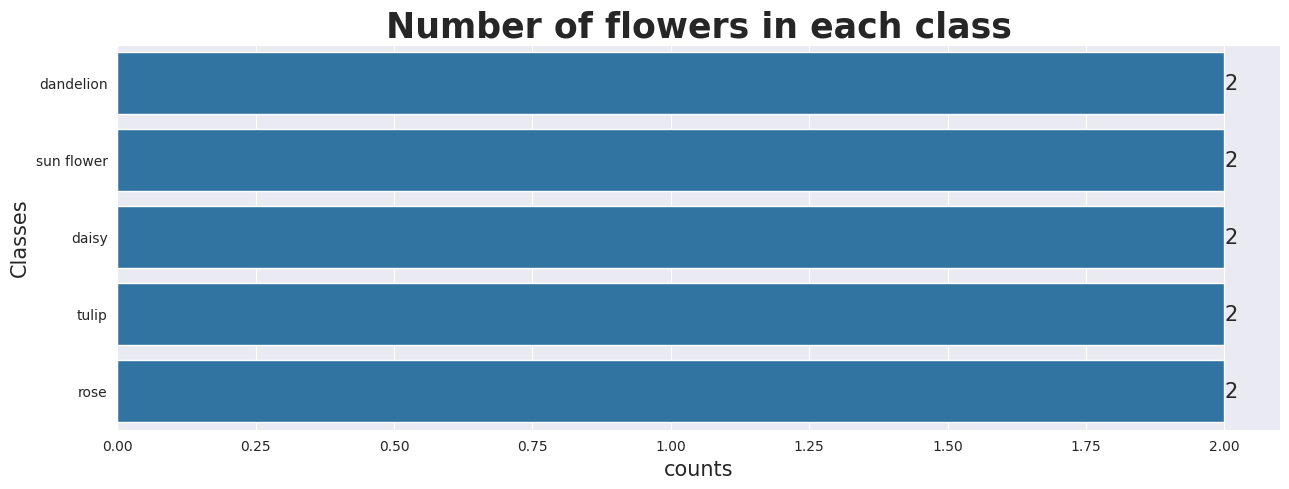

In [14]:
# An empty list to store number of samples in each class
counts = []

# Loop over classes and add count of each class to above list
for class_name in classes :
    counts.append(len(os.listdir(os.path.join(base_dir, class_name))))

# Plot the result
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=counts, y=classes)
ax.bar_label(ax.containers[0], fontsize=15)
plt.title('Number of flowers in each class', fontsize=25, fontweight='bold')
plt.xlabel('counts', fontsize=15)
plt.ylabel('Classes', fontsize=15)
plt.show()

In [15]:
print(colored(f'Number of all samples : {sum(counts)}', attrs=['bold']))

Number of all samples : 10


In [16]:
# create folder for train, validation and test set
splitfolders.ratio(
    input=base_dir, output='Images', seed=101, ratio=(0.7, 0.15, 0.15)
)

Copying files: 10 files [00:03,  2.62 files/s]


In [17]:
Images_path = '/content/flowers/Images'

 Create Data Loaders

In [18]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((250,250)),      # Resize images to a target size
        transforms.ToTensor(),             # Convert images to tensor
        transforms.Normalize((0),(1))      # Normalize images by mean=0 and std=1b
    ]
)

In [21]:
import torch.utils.data
import torchvision
import os
from termcolor import colored
from torchvision import transforms

BATCH_SIZE = 1
# Update this path to reflect the correct location of your 'Images' directory
Images_path = '/content/Images'  # Make sure this path is correct

############################### TRAIN ###############################

# Read images in train folder
train_ds = torchvision.datasets.ImageFolder( os.path.join(Images_path, 'train'), transform=transform
)

# Create a DataLoader for train images
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)
print(colored(f'TRAIN Folder :\n ', 'green', attrs=['bold']))
print(train_ds)
print('_'*100)
print()

############################# VALIDATION ###########################

# Read images in val folder
# Verify that 'val' directory exists at this location
print(os.listdir(Images_path))
val_ds = torchvision.datasets.ImageFolder(
    os.path.join(Images_path, 'val'), transform=transform
)

# Create a DataLoader for validation images
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=True
)
print(colored(f'VALIDATION Folder :\n ', 'green', attrs=['bold']))
print(val_ds)
print('_'*100)
print()

############################### TEST ###############################

# Read images in test folder
test_ds = torchvision.datasets.ImageFolder(
    os.path.join(Images_path, 'test'), transform=transform
)

# Create a DataLoader for test images
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=True
)
print(colored(f'TEST Folder :\n ', 'green', attrs=['bold']))
print(test_ds)

TRAIN Folder :
 
Dataset ImageFolder
    Number of datapoints: 5
    Root location: /content/Images/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )
____________________________________________________________________________________________________

['train', 'test', 'val']


FileNotFoundError: Found no valid file for the classes daisy, dandelion, rose, sun flower, tulip. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [22]:
import torch.utils.data
import torchvision
import os
from termcolor import colored
from torchvision import transforms

BATCH_SIZE = 1
# Update this path to reflect the correct location of your 'Images' directory
Images_path = '/content/Images'

# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((250,250)),      # Resize images to a target size
        transforms.ToTensor(),             # Convert images to tensor
        transforms.Normalize((0),(1))      # Normalize images by mean=0 and std=1b
    ]
)

############################### TRAIN ###############################

# Read images in train folder
train_ds = torchvision.datasets.ImageFolder( os.path.join(Images_path, 'train'), transform=transform
)

# Create a DataLoader for train images
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)
print(colored(f'TRAIN Folder :\n ', 'green', attrs=['bold']))
print(train_ds)
print('_'*100)
print()

############################# VALIDATION ###########################

# Read images in val folder
val_ds = torchvision.datasets.ImageFolder(
    os.path.join(Images_path, 'val'), transform=transform
)

# Create a DataLoader for validation images
val_loader = torch.utils.data.DataLoader( # Make sure val_loader is defined in this scope
    val_ds, batch_size=BATCH_SIZE, shuffle=True
)
print(colored(f'VALIDATION Folder :\n ', 'green', attrs=['bold']))
print(val_ds)
print('_'*100)
print()

############################### TEST ###############################

# Read images in test folder
test_ds = torchvision.datasets.ImageFolder(
    os.path.join(Images_path, 'test'), transform=transform
)

# Create a DataLoader for test images
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=True
)
print(colored(f'TEST Folder :\n ', 'green', attrs=['bold']))
print(test_ds)

# print shape of dataset for each set
for key, value in {'Train': train_loader, "Validation": val_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(colored(f' {key}:', 'green', attrs=['bold']))
        print(f"Shape of images [Batch_size, Channels, Height, Width]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        print('-'*45)
        break

TRAIN Folder :
 
Dataset ImageFolder
    Number of datapoints: 5
    Root location: /content/Images/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0, std=1)
           )
____________________________________________________________________________________________________



FileNotFoundError: Found no valid file for the classes daisy, dandelion, rose, sun flower, tulip. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

Plot Images

In [23]:
# Create a label map to translate labels
label_map = {
    0 : 'Daisy',
    1 : 'Dandelion',
    2 : 'Rose',
    3 : 'SunFlower',
    4 : 'Tulips'
}

In [24]:
for images, labels in train_loader :
    break

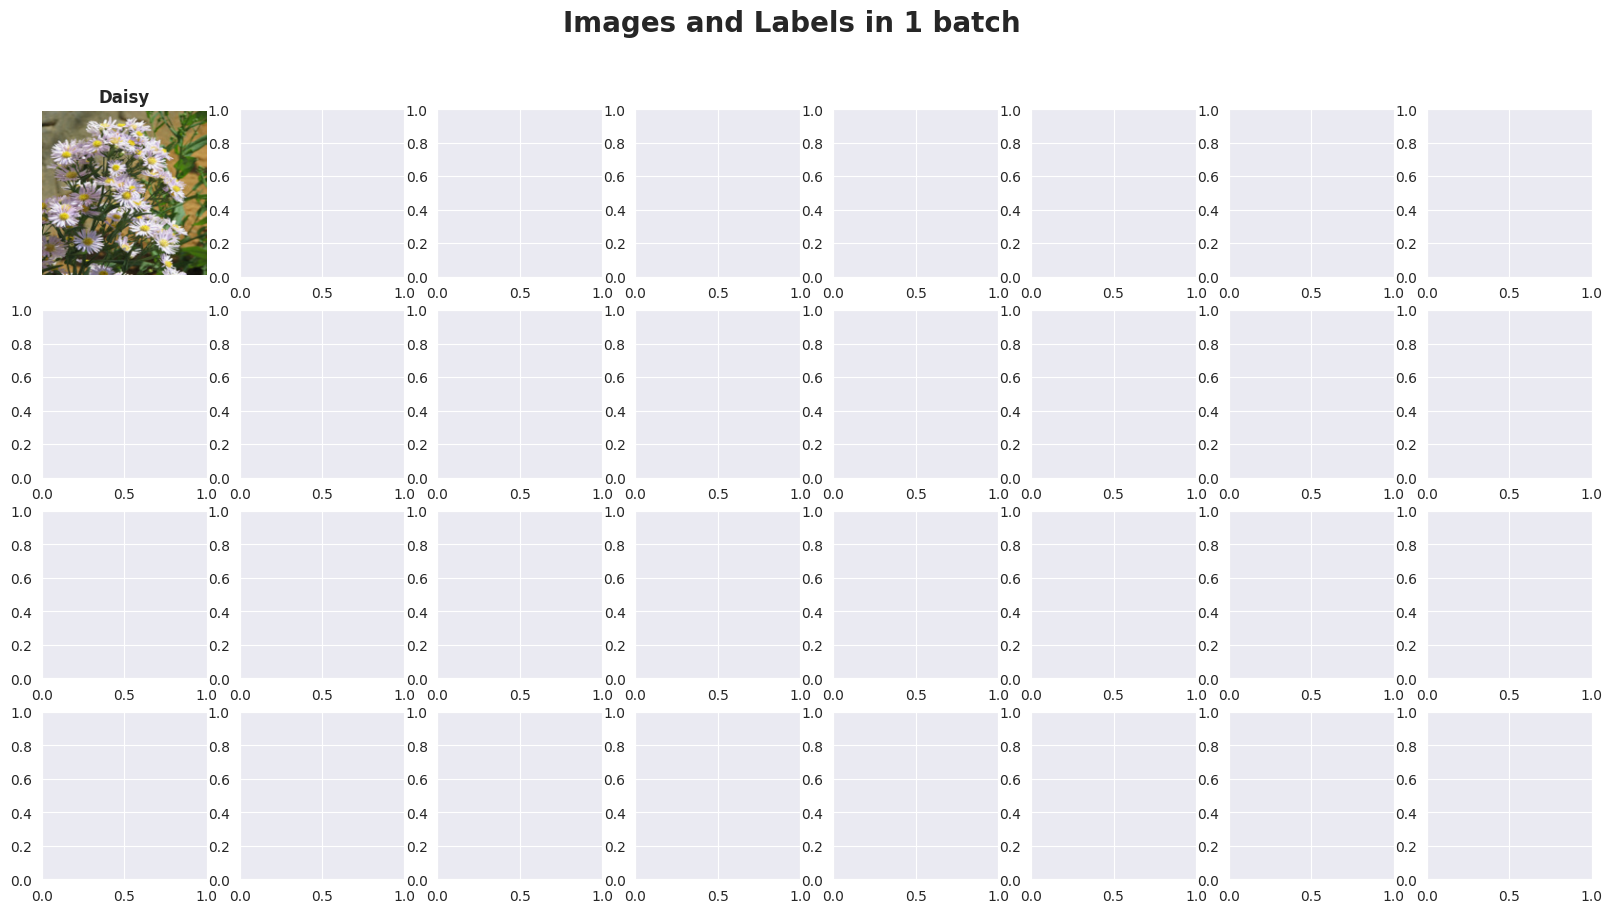

In [25]:
# Plot images and their labels in 1 batch (32 images and labels)
plt.subplots(4, 8, figsize=(20, 10))
plt.suptitle('Images and Labels in 1 batch', fontsize=20, fontweight='bold')
for i in range(BATCH_SIZE) :
    ax = plt.subplot(4, 8, i+1)
    img = torch.permute(images[i], (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_map[int(labels[i])], fontweight='bold')
plt.show()

Create a Model

load a Pretrained Model

In [26]:
# Load efficientnet_b5 weight (best weight)
weights = EfficientNet_B5_Weights.DEFAULT

# This function prepare images to feed into efficientnet_b5 model
preprocess = weights.transforms()

# Load efficientnet_b5 model with best weights
efficientnet_model = efficientnet_b5(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 112MB/s]


Freeze Pretrained Model Layers

In [27]:
# List of all layers of efficientnet_b5
for child in efficientnet_model.children() :
    print(child)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 

In [28]:
# First freeze everything
for param in efficientnet_model.parameters() :
    param.requires_grad = False

In [29]:
# Then Unfreeze some of last layers of model
for param in efficientnet_model.features[6].parameters() :
    param.requires_grad = True

Define Finall Model

In [30]:
# Number of classes
num_classes = len(classes)

class CNN(nn.Module) :
    def __init__(self, num_classes) :
        super(CNN, self).__init__()
        ####  CONVs
        self.conv_layers = efficientnet_model
        ####  Dense
        self.dense_layers = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
    def forward(self, X) :
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out


model = CNN(num_classes)

# Move new model to GPU for increase speed of processing
model.to(device)

CNN(
  (conv_layers): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

Train and Evaluate the Model 💻

Train the Model

In [31]:
# Create Criterion and Optimizer
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [32]:
import torch

# Load or create your dataset here.
# For example, if you are using torchvision.datasets:
from torchvision import datasets, transforms
dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/Flowers', transform=transforms.ToTensor())

# Continue with splitting the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32) # Adjust batch size as needed


In [34]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load or create your dataset here.
# For example, if you are using torchvision.datasets:
dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/Flowers',
                               transform=transforms.Compose([
                                   transforms.Resize((224, 224)),  # Resize all images to a common size
                                   transforms.ToTensor()
                               ]))

# Continue with splitting the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=32) # Adjust batch size as needed

In [35]:
num_epochs = 25
import numpy as np


# Define some variables to store metrics for whole project
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)

for it in range(num_epochs) :

    # Define some variabels to store metrics in each epoch
    train_loss = []
    val_loss = []
    n_correct = 0
    n_total = 0


    # Change mode to TRAIN
    model.train()

    # Currnet time
    t0 = datetime.now()

    # Fetch images from DataLoader
    for images, labels in train_loader :
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Zero Grad optimizer
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Train loss
        train_loss.append(loss.item())

        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    train_loss = np.mean(train_loss)
    train_losses[it] = train_loss
    train_accs[it] = n_correct / n_total

    # Validation
    for images, labels in val_loader :
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward padd
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Validation Loss
        val_loss.append(loss.item())

        # Validation Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    val_loss = np.mean(val_loss)
    val_losses[it] = val_loss
    val_accs[it] = n_correct / n_total

    dt = datetime.now() - t0

    # Print the result of  each epochs
    print(f'Epoch [{it+1}/{num_epochs}] -> Train Loss:{train_loss:.4f}, Train Acc:{train_accs[it]:.4f}| Val Loss:{val_loss:.4f}, Val Acc:{val_accs[it]:.4f}| Duration : {dt}')

Epoch [1/25] -> Train Loss:1.5827, Train Acc:0.4000| Val Loss:1.6759, Val Acc:0.4286| Duration : 0:00:04.713822
Epoch [2/25] -> Train Loss:1.4446, Train Acc:0.4000| Val Loss:1.7017, Val Acc:0.4286| Duration : 0:00:04.133722
Epoch [3/25] -> Train Loss:1.2491, Train Acc:0.6000| Val Loss:1.7375, Val Acc:0.5714| Duration : 0:00:04.518978
Epoch [4/25] -> Train Loss:1.0575, Train Acc:0.6000| Val Loss:1.5883, Val Acc:0.4286| Duration : 0:00:04.151887
Epoch [5/25] -> Train Loss:0.8557, Train Acc:0.8000| Val Loss:1.9303, Val Acc:0.7143| Duration : 0:00:04.649681
Epoch [6/25] -> Train Loss:0.5472, Train Acc:0.6000| Val Loss:2.4959, Val Acc:0.5714| Duration : 0:00:04.834531
Epoch [7/25] -> Train Loss:0.4220, Train Acc:0.8000| Val Loss:1.4386, Val Acc:0.5714| Duration : 0:00:03.846419
Epoch [8/25] -> Train Loss:0.3419, Train Acc:0.8000| Val Loss:1.8872, Val Acc:0.5714| Duration : 0:00:05.333948
Epoch [9/25] -> Train Loss:0.3262, Train Acc:0.8000| Val Loss:1.8262, Val Acc:0.7143| Duration : 0:00:04

Result of Trainig

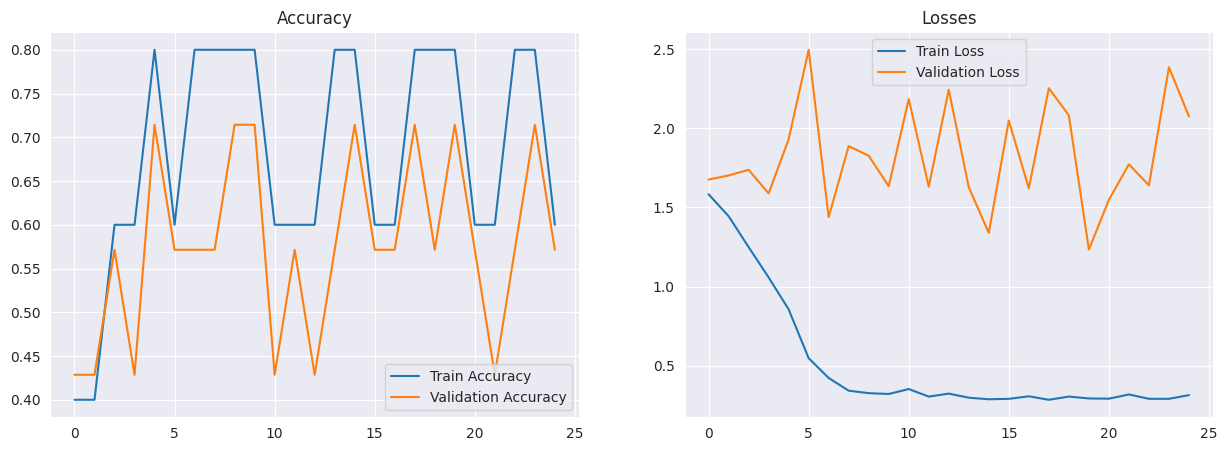

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Left plots
ax[0].plot(train_accs, label='Train Accuracy')
ax[0].plot(val_accs, label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()

# Right plots
ax[1].plot(train_losses, label='Train Loss')
ax[1].plot(val_losses, label='Validation Loss')
ax[1].set_title('Losses')
ax[1].legend()
plt.show()

Evaluate The Model

In [43]:
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms # Import transforms module

# Define your transform here
your_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image tensors
])

# Load or create your test dataset here and assign it to 'test_data'
# For example, if using ImageFolder:
test_data = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/Flowers', transform=your_transform) # Load your test dataset

# test_dataset = Dataset(test_data) # No need for this line, 'test_data' is already a Dataset
test_loader = DataLoader(test_data, batch_size=32, shuffle=False) # Use 'test_data' directly

In [45]:
# Assuming 'test_data' is your test dataset and you have necessary imports like 'DataLoader' and 'Dataset'
from torch.utils.data import DataLoader, Dataset

# test_dataset = Dataset(test_data) # Remove this line - 'test_data' is already a Dataset
test_loader = DataLoader(test_data, batch_size=32, shuffle=False) # Adjust batch_size as needed

with torch.no_grad() :
    model.eval()
    t0 = datetime.now()
    test_loss = []
    val_loss = []
    n_correct = 0
    n_total = 0

    for images, labels in test_loader : # 'test_loader' is now defined
        # Move input data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Train Loss
        test_loss.append(loss.item())

        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    test_loss = np.mean(test_loss) # Use test_loss here, not train_loss
    test_acc = n_correct / n_total # Calculate test accuracy
    dt = datetime.now() - t0
    print(colored(f'Loss:{test_loss:.4f}\nAccuracy:{test_acc:.4f}\nDuration:{dt}', 'green', attrs=['bold'])) # Print test accuracy

Loss:1.5010
Accuracy:0.2000
Duration:0:00:02.930124


Result(Plot - Confusion Matrix)

IndexError: index 10 is out of bounds for dimension 0 with size 10

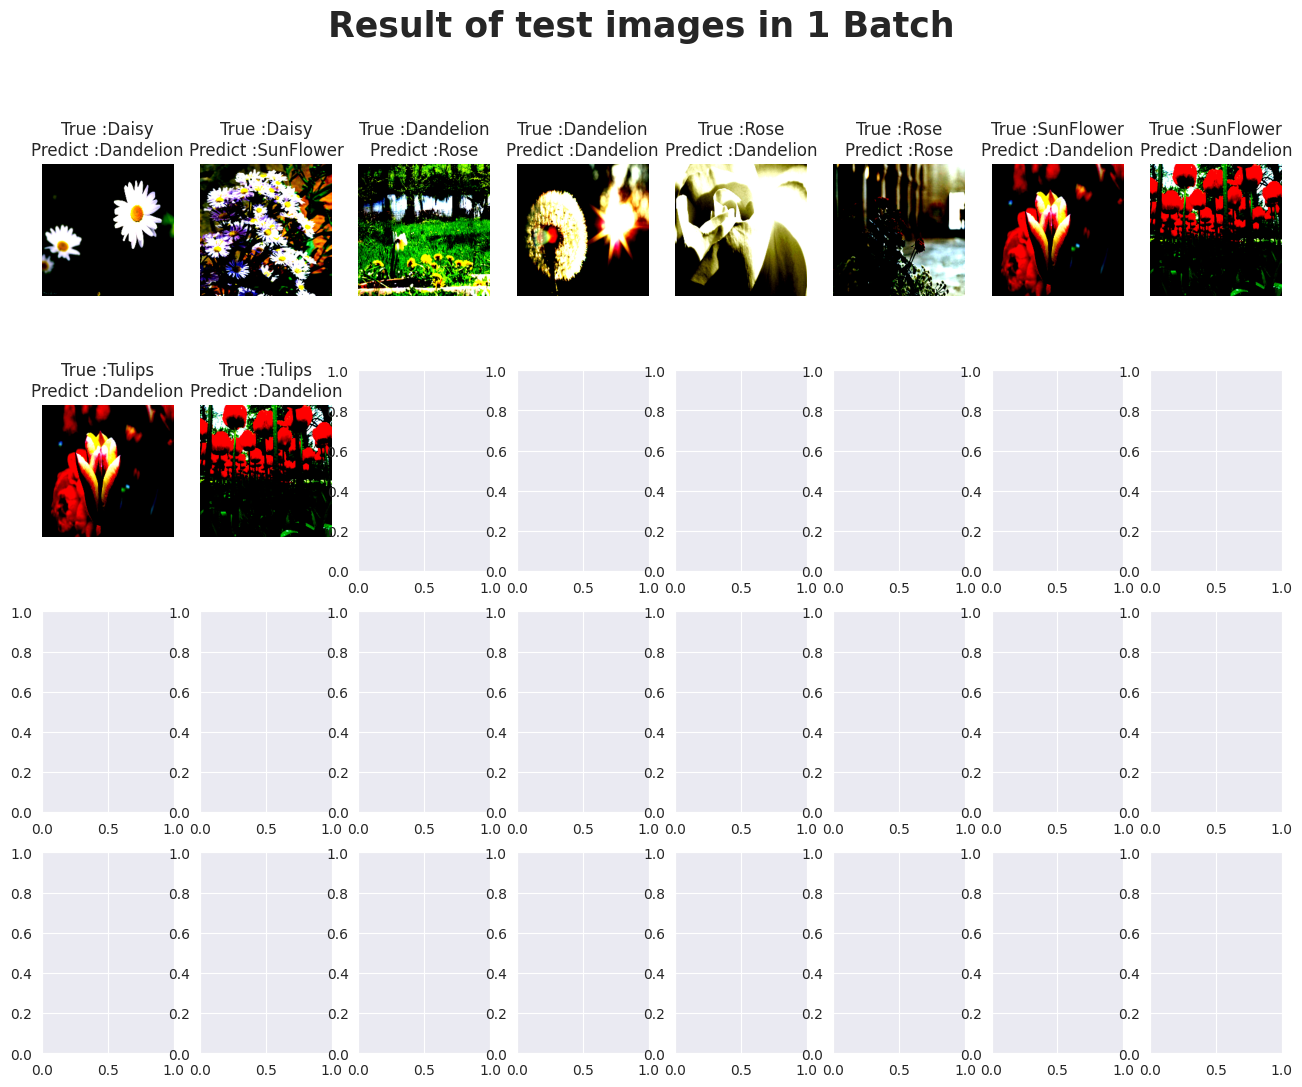

In [48]:
# Move model to CPU
cpu_model = model.cpu()

# Get 1 batch of test_loader
for imgs, labels in test_loader :
    break

# Plot 1 batch of test_loader images with True and Predicted label
plt.subplots(4, 8, figsize=(16, 12))
plt.suptitle('Result of test images in 1 Batch', fontsize=25, fontweight='bold')
for i in range(32) :
    ax = plt.subplot(4, 8, i+1)
    img = torch.permute(imgs[i], (1, 2, 0))
    plt.imshow(img)
    label = label_map[int(labels[i])]
    img = img[i].unsqueeze(0)
    img = imgs[i].unsqueeze(0)
    out = cpu_model(img)
    predict = label_map[int(out.argmax())]
    plt.title(f'True :{label}\nPredict :{predict}')
    plt.axis('off')

plt.show()

In [47]:
# Get out 2 list include y_true and y_pred for use in confusion_matrix
model = model.to(device)

y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.numpy()
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()

    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.14      0.50      0.22         2
         2.0       0.50      0.50      0.50         2
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         2

    accuracy                           0.20        10
   macro avg       0.13      0.20      0.14        10
weighted avg       0.13      0.20      0.14        10



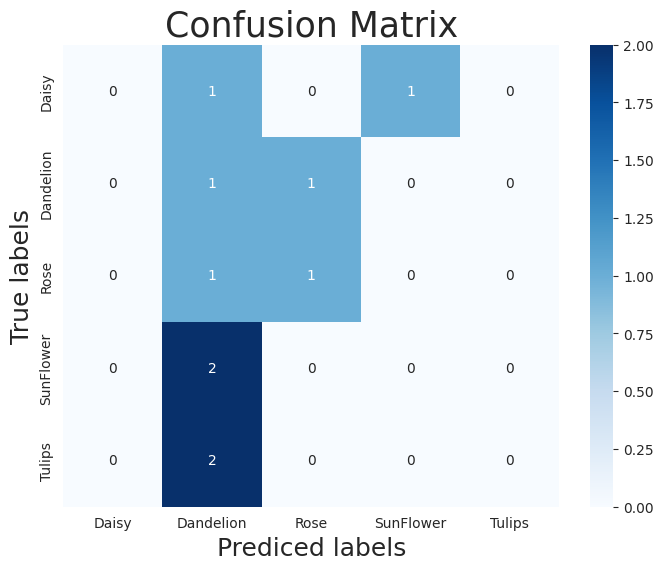

In [49]:
classes = label_map.values()

print(classification_report(y_true, y_pred))

def plot_confusion_matrix(y_test, y_prediction):
    '''Plotting Confusion Matrix'''
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='', cmap="Blues")
    ax.set_xlabel('Prediced labels', fontsize=18)
    ax.set_ylabel('True labels', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.show()


plot_confusion_matrix(y_true, y_pred)